# CISC 351/372 Advanced Data Analytics Group Project

## Group 8: Political Sentiment Analysis In Liberal and Conservative Reddit Communities

### RQ2: How does political sentiment differ between liberal and conservative Reddit communities?

This notebook contains the code to answer the second research question.

## Imports

In [ ]:
%pip install nrclex
%pip install nltk NRCLex tqdm


In [ ]:
import json
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from nrclex import NRCLex
from joblib import Parallel, delayed
from collections import Counter

import nltk
nltk.download('punkt')



### Prepare Dataset

In [2]:
with open("Conservative.json", "r") as file:
    con_data = json.load(file)

with open("Liberal.json", "r") as file:
    lib_data = json.load(file)

# Convert JSON to a DataFrame
con_df = pd.DataFrame(con_data)
lib_df = pd.DataFrame(lib_data)

# Check the structure
print(con_df.head())
print(lib_df.head())

   WordCount                                            article  \
0       1101  Retired US Army General Wesley Clark called fo...   
1       1312  If a place isn't too far gone to start with, t...   
2        550  On Palm Sunday, the Trust Women Wichita aborti...   
3        762  CARACAS, Venezuela (AP) — A leading Venezuelan...   
4        311  It’s been less than a month since Trump – afte...   

  author_flair_text  created_utc               domain  num_comments  score  \
0                     1437509071             wsws.org             3     18   
1                     1620141553  americanthinker.com            18    313   
2                     1586381822       liveaction.org             0      1   
3                     1399316632       news.yahoo.com             0      7   
4                     1473095574         redstate.com            10     17   

                                                 url       url_domain  \
0  http://www.wsws.org/en/articles/2015/07/21/cla...   

### Extract Emotions from Articles using NRCLex

In [5]:
# Function to extract emotions
def get_emotions(text):
    try:
        return NRCLex(text).raw_emotion_scores
    except:
        return {}

# Joblib-based parallel processing
def process_with_joblib(articles):
    return Parallel(n_jobs=-1)(
        delayed(get_emotions)(text) for text in tqdm(articles)
    )

# Save to pickle
def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load from pickle
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# === PROCESS CONSERVATIVE DATA ===
if os.path.exists("con_emotions.pkl"):
    print("Loading conservative emotions from file...")
    con_emotions = load_pickle("con_emotions.pkl")
else:
    print("Processing conservative emotions...")
    con_articles = con_df['article'].tolist()
    con_emotions = process_with_joblib(con_articles)
    save_pickle(con_emotions, "con_emotions.pkl")

# === PROCESS LIBERAL DATA ===
if os.path.exists("lib_emotions.pkl"):
    print("Loading liberal emotions from file...")
    lib_emotions = load_pickle("lib_emotions.pkl")
else:
    print("Processing liberal emotions...")
    lib_articles = lib_df['article'].tolist()
    lib_emotions = process_with_joblib(lib_articles)
    save_pickle(lib_emotions, "lib_emotions.pkl")

# === Save results back into DataFrame ===
con_df['emotions'] = con_emotions
lib_df['emotions'] = lib_emotions
print("All done ✅")


Processing conservative emotions...


100%|██████████| 79573/79573 [04:15<00:00, 311.39it/s]


Processing liberal emotions...


100%|██████████| 72488/72488 [06:02<00:00, 199.79it/s]


All done ✅


### Add Results and Normalize

In [11]:
# Helper function to combine all emotion scores
def aggregate_emotions(emotion_series):
    total = Counter()
    for emo_dict in emotion_series:
        total.update(emo_dict)
    return total

# Aggregate all emotions for each subreddit
con_total = aggregate_emotions(con_df['emotions'])
lib_total = aggregate_emotions(lib_df['emotions'])

# Convert to DataFrame for comparison
emotion_df = pd.DataFrame({
    "Conservative": pd.Series(con_total),
    "Liberal": pd.Series(lib_total)
}).fillna(0)

# Normalize by turning raw counts to percentages
emotion_df['Conservative %'] = emotion_df['Conservative'] / emotion_df['Conservative'].sum()
emotion_df['Liberal %'] = emotion_df['Liberal'] / emotion_df['Liberal'].sum()

# Show emotions by count in each subreddit
top_con = emotion_df.sort_values("Conservative", ascending=False)
top_lib = emotion_df.sort_values("Liberal", ascending=False)

display(top_con)
display(top_lib)


,Conservative,Liberal,Conservative %,Liberal %
positive,4283760,7889828,0.214211,0.233967
negative,3213129,5098422,0.160674,0.151190
trust,2968177,5085007,0.148425,0.150792
fear,2001194,3028470,0.100070,0.089807
anticipation,1784199,3240020,0.089220,0.096081
anger,1533443,2353327,0.076680,0.069786
sadness,1420998,2265117,0.071058,0.067171
joy,1235491,2217659,0.061781,0.065763
disgust,816430,1197214,0.040826,0.035503
surprise,741032,1346837,0.037056,0.039940


,Conservative,Liberal,Conservative %,Liberal %
positive,4283760,7889828,0.214211,0.233967
negative,3213129,5098422,0.160674,0.151190
trust,2968177,5085007,0.148425,0.150792
anticipation,1784199,3240020,0.089220,0.096081
fear,2001194,3028470,0.100070,0.089807
anger,1533443,2353327,0.076680,0.069786
sadness,1420998,2265117,0.071058,0.067171
joy,1235491,2217659,0.061781,0.065763
surprise,741032,1346837,0.037056,0.039940
disgust,816430,1197214,0.040826,0.035503


### Plot Results

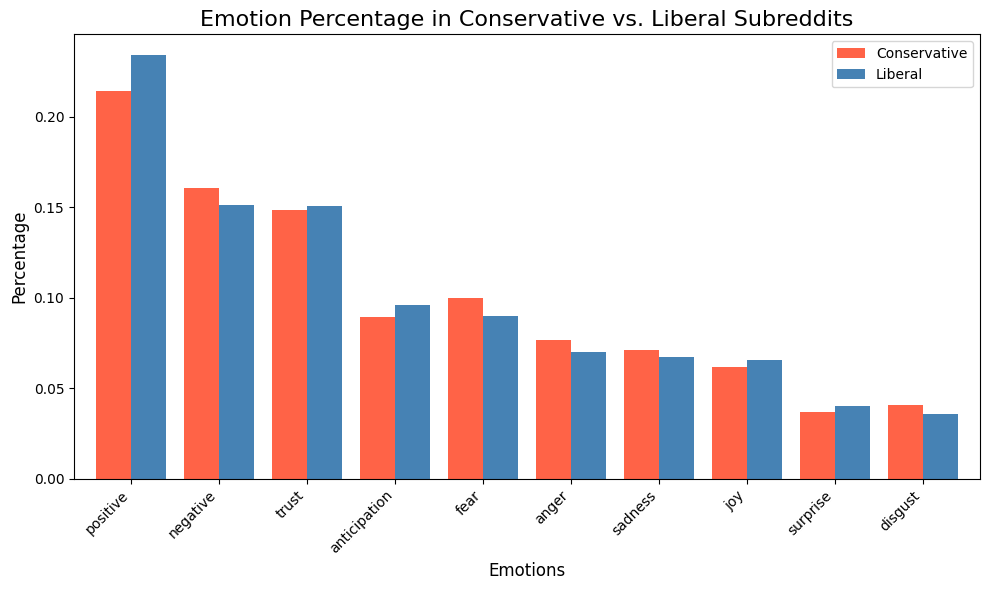

In [9]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Sort the DataFrame by the 'Conservative %' (or 'Liberal %') column in descending order
emotion_df_sorted = emotion_df[['Conservative %', 'Liberal %']].sort_values(by='Liberal %', ascending=False)

# Plotting percentages for each subreddit
# For each emotion, plot a bar for Conservative and Liberal, side by side
emotion_df_sorted[['Conservative %', 'Liberal %']].plot(kind='bar', width=0.8, color=['#FF6347', '#4682B4'], ax=plt.gca())

# Adding labels and title
plt.title("Emotion Percentage in Conservative vs. Liberal Subreddits", fontsize=16)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

# Show legend
plt.legend(["Conservative", "Liberal"], loc="upper right")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


### Results Interpretation

The Liberal community exhibits a slightly more positive sentiment overall (23.40%) compared to the Conservative community (21.42%). On the other hand, the Conservative community shows a slightly more negative sentiment (16.07%) than the Liberal community (15.12%).

In terms of specific emotions:

The Liberal subreddits express higher percentages of trust (15.08%), anticipation (9.61%), joy (6.58%), and surprise (3.99%) compared to the Conservative subreddits.

The Conservative subreddits, however, show stronger feelings of fear (10.01%), anger (7.67%), sadness (7.11%), and disgust (4.08%).

These patterns suggest that the Liberal community tend to have a more optimistic and hopeful tone, while the Conservative community expresses stronger feelings of fear and discontent. Although the sentiment differences are subtle, they reflect contrasting emotional tendencies between the two political groups.

